## 4.5 X-ception, ResNet50, Inceptionv3

Data Preprocess of X-ception, ResNet50, Inceptionv3

In [ ]:
import os
import numpy as np
from os import listdir
from imageio import imread
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils.image_utils import img_to_array

import PIL
import matplotlib.pyplot as plt

In [ ]:
# Settings 
num_classes = 10
test_size = 0.2

read image and convert to 3d array

In [ ]:
def get_img(data_path): 
  ## Getting image array from path: 
  img = PIL.Image.open(data_path)
  img = img.convert("L")
  img = img_to_array(img)
  img = np.resize(img, (100, 100, 3))
  return img

Get dataset from picture and then split to train and test set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/Dataset"

## Getting all data from data path
labels = sorted(listdir(dataset_path))
X = []
Y = []
for i, label in enumerate(labels): 
  data_path = dataset_path + "/" + label
  
  for data in listdir(data_path): 
    img = get_img(data_path + "/" + data)
    X.append(img)
    Y.append(i)
## create dataset 
X = 1 - np.array(X).astype("float32") /255
Y = np.array(Y).astype("float32")
Y = to_categorical(Y, num_classes)

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, random_state = 42)
print(X.shape)
print(X_test.shape)
print(Y.shape)
print(Y_test.shape)


Mounted at /content/drive
(1649, 100, 100, 3)
(413, 100, 100, 3)
(1649, 10)
(413, 10)


In [ ]:
import tensorflow as tf
from numpy.random import seed
seed(123)
tf.random.set_seed(123)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn as sk
import time
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras import initializers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import math 
from keras import applications

In [ ]:
img_height = 100
img_width = 100

In [ ]:
# Creating validation set and training set by partitioning the current training set
val = X[:274]
partial = X[274:]
val_labels = Y[:274]
partial_labels = Y[274:]

In [ ]:
print(X.shape)
print(val.shape)
print(partial.shape)

(1649, 100, 100, 3)
(274, 100, 100, 3)
(1375, 100, 100, 3)


# X-ception

When building the last layers of X-ception, I first added the GlobalAveragePooling2D() to create feature map for each cagetory. I then added dense layer but it didn't help. I tried several drop out values and found 0.4 the best. After tuning the last layers, I unfreeze the base model and retrain the whole model with a very low learning rate. I've tried some different values of learning rate and found lr = le-5 the best. When fit the model, I used EarlyStopping function in keras to find the optimal epoch value (=27) to avoid the issue of overfiffting.

In [ ]:
#Load the Xception pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [ ]:
#To prevent the base model being retrained
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))

In [ ]:
#Preprocess inputs as expected by Xception
#scale from (0,1) to (-1,1)
x = tf.keras.applications.xception.preprocess_input(inputs)

In [ ]:
#Build the last layers
#Use the functional API method in Keras to illustrate this approach
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv_17 (TFOpLam  (None, 100, 100, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_17 (TFOpLa  (None, 100, 100, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X, Y, epochs=3, validation_data=(X_test,Y_test))

Epoch 1/3
52/52 [==============================] - 5s 58ms/step - loss: 2.2971 - accuracy: 0.1055 - val_loss: 2.2941 - val_accuracy: 0.1259
Epoch 2/3
52/52 [==============================] - 2s 37ms/step - loss: 2.2825 - accuracy: 0.1686 - val_loss: 2.2829 - val_accuracy: 0.1453
Epoch 3/3
52/52 [==============================] - 2s 37ms/step - loss: 2.2684 - accuracy: 0.1740 - val_loss: 2.2713 - val_accuracy: 0.1743


In [ ]:
# Fine-tuning
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv_17 (TFOpLam  (None, 100, 100, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_17 (TFOpLa  (None, 100, 100, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = model.fit(partial, partial_labels, batch_size = 16, 
                    epochs = 100, validation_data =(val, val_labels), 
                    callbacks =[earlystopping])

Epoch 1/100
86/86 [==============================] - 11s 84ms/step - loss: 2.1110 - accuracy: 0.1927 - val_loss: 1.8732 - val_accuracy: 0.2920
Epoch 2/100
86/86 [==============================] - 7s 85ms/step - loss: 1.7513 - accuracy: 0.3236 - val_loss: 1.7132 - val_accuracy: 0.2993
Epoch 3/100
86/86 [==============================] - 7s 78ms/step - loss: 1.4120 - accuracy: 0.4465 - val_loss: 1.4318 - val_accuracy: 0.4234
Epoch 4/100
86/86 [==============================] - 7s 77ms/step - loss: 1.2753 - accuracy: 0.4996 - val_loss: 1.2722 - val_accuracy: 0.5182
Epoch 5/100
86/86 [==============================] - 6s 73ms/step - loss: 1.1707 - accuracy: 0.5462 - val_loss: 1.1859 - val_accuracy: 0.5803
Epoch 6/100
86/86 [==============================] - 6s 74ms/step - loss: 1.1123 - accuracy: 0.5862 - val_loss: 1.0707 - val_accuracy: 0.5876
Epoch 7/100
86/86 [==============================] - 6s 73ms/step - loss: 1.0861 - accuracy: 0.5876 - val_loss: 1.2931 - val_accuracy: 0.4708
Epoch

In [ ]:
score = model.evaluate(X_test,Y_test, batch_size=16)

26/26 [==============================] - 1s 20ms/step - loss: 0.3534 - accuracy: 0.8983


The model accuracy for test dataset is 89.83%.

# ResNet50

When building the last layers of ResNet50, I first added the GlobalAveragePooling2D() to create feature map for each cagetory. I then added a dense layer. I tried different unit values and different activation functions and found that unit = 1500 and sigmoid activation improves the model performance the best. I also tried adding another dense layer but it didn't help. I tried several drop out values and found 0.4 the best. After tuning the last layers, I unfreeze the base model and retrain the whole model with a very low learning rate. I've tried some different values of learning rate and found lr = le-5 the best. When fit the model, I used EarlyStopping function in keras to find the optimal epoch value (=27) to avoid the issue of overfiffting. 

In [ ]:
#Load the Xception pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [ ]:
#To prevent the base model being retrained
base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))

# Preprocess inputs as expected by ResNet
x = tf.keras.applications.resnet.preprocess_input(inputs)

In [ ]:
#Build the last layers
#Use the functional API method in Keras to illustrate this approach
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1500, activation="sigmoid")(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem_19  (None, 100, 100, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_19 (TFOpLamb  (None, 100, 100, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X, Y, epochs=3, validation_data=(X_test,Y_test))

Epoch 1/3
52/52 [==============================] - 6s 58ms/step - loss: 2.6627 - accuracy: 0.1019 - val_loss: 2.3031 - val_accuracy: 0.1332
Epoch 2/3
52/52 [==============================] - 2s 40ms/step - loss: 2.4126 - accuracy: 0.1358 - val_loss: 2.2197 - val_accuracy: 0.1985
Epoch 3/3
52/52 [==============================] - 2s 44ms/step - loss: 2.2966 - accuracy: 0.1625 - val_loss: 2.1997 - val_accuracy: 0.1743


In [ ]:
# fine-tuning
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem_19  (None, 100, 100, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_19 (TFOpLamb  (None, 100, 100, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = model.fit(partial, partial_labels, batch_size = 16, 
                    epochs = 100, validation_data =(val, val_labels), 
                    callbacks =[earlystopping])

Epoch 1/100
86/86 [==============================] - 13s 89ms/step - loss: 2.2641 - accuracy: 0.1702 - val_loss: 1.9824 - val_accuracy: 0.3869
Epoch 2/100
86/86 [==============================] - 6s 73ms/step - loss: 1.8381 - accuracy: 0.3185 - val_loss: 1.5089 - val_accuracy: 0.4672
Epoch 3/100
86/86 [==============================] - 6s 72ms/step - loss: 1.3676 - accuracy: 0.4815 - val_loss: 1.4244 - val_accuracy: 0.4307
Epoch 4/100
86/86 [==============================] - 7s 76ms/step - loss: 1.1295 - accuracy: 0.5615 - val_loss: 1.1015 - val_accuracy: 0.5839
Epoch 5/100
86/86 [==============================] - 6s 73ms/step - loss: 0.8810 - accuracy: 0.6618 - val_loss: 0.7937 - val_accuracy: 0.7263
Epoch 6/100
86/86 [==============================] - 6s 72ms/step - loss: 0.8137 - accuracy: 0.6851 - val_loss: 1.0521 - val_accuracy: 0.6314
Epoch 7/100
86/86 [==============================] - 6s 74ms/step - loss: 0.7253 - accuracy: 0.7265 - val_loss: 0.6256 - val_accuracy: 0.8066
Epoch

In [ ]:
score = model.evaluate(X_test,Y_test, batch_size=16)

26/26 [==============================] - 1s 23ms/step - loss: 0.2531 - accuracy: 0.9225


The model accuracy for test dataset is 92.25%.

# Inceptionv3

When building the last layers of Inceptionv3, I first added the GlobalAveragePooling2D() to create feature map for each cagetory. I then added a dense layer of 1200 units with relu activation and found model performance improved. I tried other activation methods and model didn't improve. I also tried adding another dense layer and performance decreased. I tried several drop out values and found 0.3 the best. After tuning the last layers, I unfreeze the base model and retrain the whole model with a very low learning rate. I've tried some different values of learning rate and found lr = le-6 the best. When fit the model, I used EarlyStopping function in keras to find the optimal epoch value to avoid the issue of overfiffting.

In [ ]:
seed(123)
tf.random.set_seed(123)

In [ ]:
#Load the Xception pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model = keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [ ]:
#To prevent the base model being retrained
base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))

# Preprocess inputs as expected by ResNet
x = tf.keras.applications.inception_v3.preprocess_input(inputs)

In [ ]:
#Build the last layers
#Use the functional API method in Keras to illustrate this approach
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1200, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X, Y, epochs=3, validation_data=(X_test,Y_test))
score = model.evaluate(X_test,Y_test, batch_size=16)

Epoch 1/3
52/52 [==============================] - 7s 51ms/step - loss: 1.8960 - accuracy: 0.3505 - val_loss: 1.3733 - val_accuracy: 0.4843
Epoch 2/3
52/52 [==============================] - 1s 26ms/step - loss: 1.2632 - accuracy: 0.5561 - val_loss: 1.0339 - val_accuracy: 0.6852
Epoch 3/3
26/26 [==============================] - 0s 17ms/step - loss: 0.9495 - accuracy: 0.6925


In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 100, 100, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 100, 100, 3)      0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = model.fit(partial, partial_labels, batch_size = 16, 
                    epochs = 100, validation_data =(val, val_labels), 
                    callbacks =[earlystopping])

Epoch 1/100
52/52 [==============================] - 11s 101ms/step - loss: 2.0680 - accuracy: 0.2970 - val_loss: 1.4040 - val_accuracy: 0.5267
Epoch 2/100
52/52 [==============================] - 3s 61ms/step - loss: 1.4204 - accuracy: 0.4691 - val_loss: 1.5199 - val_accuracy: 0.4041
Epoch 3/100
52/52 [==============================] - 3s 64ms/step - loss: 1.2795 - accuracy: 0.4824 - val_loss: 1.1156 - val_accuracy: 0.5692
Epoch 4/100
52/52 [==============================] - 3s 64ms/step - loss: 1.1120 - accuracy: 0.5673 - val_loss: 1.0592 - val_accuracy: 0.6129
Epoch 5/100
52/52 [==============================] - 3s 64ms/step - loss: 0.8865 - accuracy: 0.6618 - val_loss: 0.9533 - val_accuracy: 0.5934
Epoch 6/100
52/52 [==============================] - 3s 64ms/step - loss: 1.1001 - accuracy: 0.5976 - val_loss: 0.7834 - val_accuracy: 0.7403
Epoch 7/100
52/52 [==============================] - 3s 64ms/step - loss: 0.7892 - accuracy: 0.7139 - val_loss: 0.6755 - val_accuracy: 0.7367
Epoc

In [ ]:
score = model.evaluate(X_test,Y_test, batch_size=16)

26/26 [==============================] - 1s 21ms/step - loss: 0.3001 - accuracy: 0.9007


The Inceptionv3 model has a accuracy of 90.07%. 

5. Model Comparison

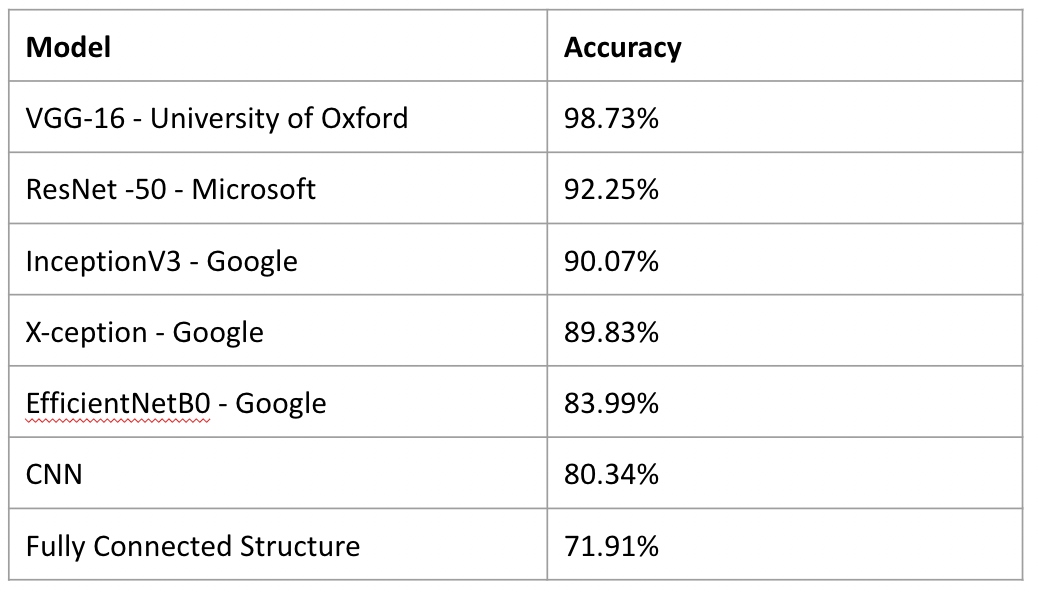